# A Comparison of Metascores and User Reviews
I'm interested in the relationship between professional and amateur opinions of games, so I thought metacritic would be a good place to start. Let's get scraping.

We'll use pandas for storing the data, and selenium for the heavy lifting.

In [1]:
import pandas as pd
from selenium import webdriver
import os

We'll use selenium for the scraping itself, and pandas to store the data.

In [2]:
CHROMEDRIVER_PATH = '/usr/lib/chromium-browser/chromedriver' # modify this as you need
CSV_DIR = '/home/tim/Desktop/'

We will store the full title (game title + platform) in `title`, the metascore in `metascore`, the average user score in `user`, and the date in `date` (to be converted to index later).

In [3]:
br = webdriver.Chrome('/usr/lib/chromium-browser/chromedriver')
df = pd.DataFrame(columns = ['title', 'metascore', 'user', 'date']) #

Make sure you have ample time for this: it will take over an hour to download. All we're doing is going across all 150 pages, and collecting the results into `df` (I skipped over this step when I was editing this .ipynb file, because I already had the data). 

In [ ]:
BASE_URL = 'http://www.metacritic.com/browse/games/score/metascore/all/all/filtered?sort=desc'

LIST_CSSS = '#main > div.module.filter.score_filter > div.module.products_module.list_product_condensed_ranked_module > div.body > div.body_wrap > div > div > div'
TITLE_CSSS = 'div.product_title'
METASCORE_CSSS = 'div.product_item.product_score > div'
USERSCORE_CSSS = 'div.product_item.product_userscore_txt > span.data'
DATE_CSSS = 'div.product_item.product_date'

for n in range(150):
    # to see where you are currently.
    print('on page {}'.format(n+1))
    
    # build url
    url = BASE_URL
    if n > 0:
        url += '&page={}'.format(n) # if we're not on page 1, add the page k/v url encoded argument
        
    # get page
    br.get(url)
    
    # collect the info we need
    try:
        # select the whole list
        prods = br.find_elements_by_css_selector(LIST_CSSS)

        # select each element we want
        titles = [prod.find_element_by_css_selector(TITLE_CSSS).text for prod in prods]
        metascores = [prod.find_element_by_css_selector(METASCORE_CSSS).text for prod in prods]
        userscores = [prod.find_element_by_css_selector(USERSCORE_CSSS).text for prod in prods]
        dates = [prod.find_element_by_css_selector(DATE_CSSS).text for prod in prods]
    except:
        print('failed')
    
    # add it to `df`
    df = df.append(pd.DataFrame(data = {'title': titles, 'metascore': metascores, 'user': userscores, 'date': dates}))

In [5]:
df.head()

,date,title,platform,metascore,user
0,1998-11-23,The Legend of Zelda: Ocarina of Time,N64,99.0,9.2
1,2000-09-20,Tony Hawk's Pro Skater 2,PS,98.0,7.4
2,2008-04-29,Grand Theft Auto IV,PS3,98.0,7.5
3,1999-09-08,SoulCalibur,DC,98.0,8.6
4,2008-04-29,Grand Theft Auto IV,X360,98.0,7.9


Now, we need to convert data into the types we want.

First, let's deal with the dates

In [6]:
df['date'] = pd.to_datetime(df['date']) # convert date column to actual dates
df.set_index(df['date'], inplace=True) # set the index
df.sort_index(inplace=True)

This is a good time to write the unmodified data to a file.

In [ ]:
path = os.path.join(CSV_DIR, 'game_review.csv')
df.to_csv(path)

Now, if you want to reload this later, you can execute the following:

In [4]:
path = os.path.join(CSV_DIR, 'game_review.csv')
df = pd.read_csv(path)

Now, `metascore` and `user`. We'll convert them to floats, but we first need to select only those values that can be converted. We'll do this by defining a mask. Refer to [this SO post](https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python) for more conversion options. If you want to keep this data, then skip over this section. You'll lose ~1300 rows.

In [7]:
mask = pd.to_numeric(df['user'], errors='coerce').notnull() & \
       pd.to_numeric(df['metascore'], errors='coerce').notnull()
    
df = df[mask]

Casting will go without fuss now:

In [8]:
df['user'] = df['user'].astype(float)
df['metascore'] = df['metascore'].astype(float)

There's one more stitch in our sides: each game has a platform parenthesized, like "(N64)". Ideally, we would like this to be a separate column. We'll use regexps to accomplish that.

In [ ]:
import re

def sep_title_platform(full_title):
    match = re.search('(.*) \((.*)\)$', full_title)
    return (match.group(1), match.group(2)) # group 1 corresponds to title, and group 2 to the platform

title_platform = df.loc[:, 'title'].apply(sep_title_platform)

# set title to just the game title, and add a platform column
df['title'] = title_platform.apply(lambda t: t[0])
df['platform'] = title_platform.apply(lambda t: t[1])

Now, we can look at the data. We want to compare metascores to user scores, but they are on different scales - specifically, metascore has a maximum of 100 while user score has a maximum of 10. It's a simple fix.

In [9]:
df['sc_metascore'] = df['metascore'] / 100
df['sc_user'] = df['user'] / 10

Now, we can take a difference between the two.

In [10]:
df['delta'] = df['sc_metascore'] - df['sc_user']

Ok, great. Let's check out a distribution plot of delta.

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

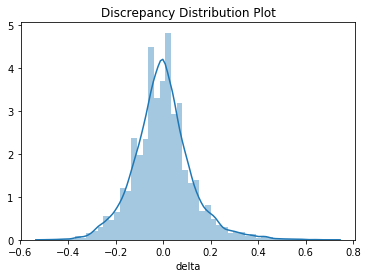

In [12]:
sns.distplot(df['delta'])
plt.title('Discrepancy Distribution Plot')
plt.show()

Hmm, looks almost normal. Let's check.

In [13]:
from scipy.stats import jarque_bera

jarque_bera(df['delta'])

(2355.4502748912682, 0.0)

Not encouraging. Is it log-normal?

In [14]:
import numpy as np

jarque_bera(np.log1p(df['delta']))

(1265.8814108236681, 0.0)

Apparently not. I am in no way a statistician. Let's move on.

One thing I've noticed with game reviews is that they seem to deviate more and more from what the average user thinks of it. It seems like I hear IGN hyping the next Call of Duty as a real game-changer, just to hear disappointed fans after the release. Let's test this hypothesis.

A good start would be to check pearson's correlation coefficient.

In [15]:
deltas = df['delta']

# create an integer time series by converting the dates to unix timestamps
times = (pd.Series(deltas.index) - pd.to_datetime('1970')).dt.total_seconds()

In [16]:
from scipy.stats import pearsonr
pearsonr(times, deltas)

(0.26633855987433053, 9.098117253138759e-220)

That's not a very strong correlation. Maybe a plot would show us better?

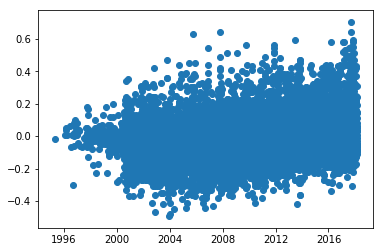

In [17]:
plt.scatter(deltas.index, deltas)
plt.show()

It certainly doesn't look like there's much correlation. That makes sense though. On smaller timescales, there can be a ton of variation. We should instead look at averages over time. A rolling average is what we're looking for.

In [18]:
window = 365 # chosen arbitrarily
rolling = deltas.rolling(window).mean().dropna()
times = (pd.Series(rolling.index) - pd.to_datetime('1970')).dt.total_seconds()

In [19]:
pearsonr(times, rolling)

(0.92454418215698186, 0.0)

That is very promising!

In [20]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(times, rolling)
abline_values = pd.Series([slope * i + intercept for i in times])

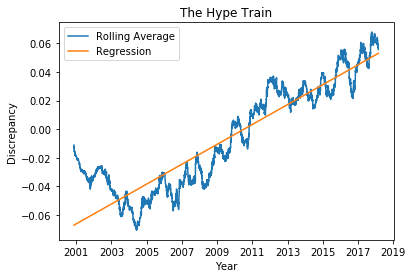

In [21]:
plt.plot(rolling.index, rolling, label='Rolling Average')
plt.plot(rolling.index, abline_values, label='Regression')
plt.xlabel('Year')
plt.ylabel('Discrepancy')
plt.legend()
plt.title('The Hype Train')
plt.show()

There is a fairly obvious trend from about 2005 to the latest data. Remember, a positive discrepancy means that the metascore is higher than the average user score. Stated differently, the 'critics' thought the game was better than it was. 

Obviously, the reasons for such a trend are not one-dimensional. It's possible that players bitter about their poor purchases judge games much more harshly than the critics. However, I would point towards AAA companies increasing their budgets on games, particularly towards marketing. I think it is fair to say the incentives are different. Players just want to play good games. At the end of the day, critics review games for money. Who is footing the bill? Perhaps it is the game developers with the clear incentive of higher sales.

I'm not suggesting that we shouldn't take professional critic reviews into account. Maybe I'm just rehashing popular advice, but I suggest that consumers take these reviews with a grain of salt. I think we would be better off if game companies stopped incentivizing game review companies to write good reviews for their games, as we would get more objective reviews about our games, and we may also get better games.

In the future, I will try to gather data on marketing costs and more directly see if this correlation holds. Maybe someone else will beat me to it :).